In [1]:
# change this to the right path if you use a different path
# or specify the ORCA_PATH environmental variable
import os
import sys
if os.getenv("ORCA_PATH"):
    ORCA_PATH = os.getenv("ORCA_PATH")
else:
    ORCA_PATH = "../orca"
sys.path.append(ORCA_PATH)

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import orca_predict 
orca_predict.load_resources(models=['32M','256M'],use_cuda=True)
from orca_predict import *

In <PYTHONPATH>/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In <PYTHONPATH>/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In <PYTHONPATH>/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [4]:
#plot an example prediction with 32Mb input
import torch
chrm, pos = 'chr9',110900000
with torch.no_grad():
    sequence = hg38.get_encoding_from_coords(chrm, pos-16000000, pos+16000000 )[None,:,:]
    outputs = genomepredict(sequence, chrm, mpos=pos, wpos=pos , \
                                targets = [torch.FloatTensor(target_h1esc.get_feature_data(chrm, pos-16000000, pos+16000000)[None,:,:]),\
                                          torch.FloatTensor(target_hff.get_feature_data(chrm, pos-16000000, pos+16000000)[None,:,:])], use_cuda=False)
    
genomeplot(outputs,show_genes=False, maskpred=False, vmin=-0.85, vmax=1.7, file='./figures/example_prediction.pdf')

<PYTHONPATH>/lib/python3.7/site-packages/cooltools/lib/numutils.py:1317: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
<PYTHONPATH>/lib/python3.7/site-packages/cooltools/lib/numutils.py:1317: RuntimeWarning: divide by zero encountered in true_divide
  val_cur = ar_cur / armask_cur
../orca/orca_predict.py:396: RuntimeWarning: Mean of empty slice
  axis=4,
<PYTHONPATH>/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
../orca/orca_predict.py:398: RuntimeWarning: Mean of empty slice
  axis=2,


In [5]:
#plot an example prediction with 256Mb input

from selene_utils2 import * 
sampler_h1esc = RandomPositionsSamplerHiC(
                 reference_sequence = MemmapGenome(ORCA_PATH+'/resources/Homo_sapiens.GRCh38.dna.primary_assembly.fa', memmapfile='./resources/Homo_sapiens.GRCh38.dna.primary_assembly.fa.mmap'),
                 target= Genomic2DFeatures([ORCA_PATH+'/resources/4DNFI9GMP2J8.rebinned.mcool::/resolutions/32000'],
                           ['r8000'],
                          (8000,8000),
                          cg=True),
                 features = ['r4000'],
                 test_holdout=['chr8', 'chr9'],
                 validation_holdout= ['chr10'],
                 sequence_length= 256000000,
                 position_resolution=32000,
                 random_shift=4000,
                 random_strand=False,
                 cross_chromosome=True,
                 permute_segments=False,
                 background_cis_file=ORCA_PATH+'/resources/4DNFI9GMP2J8.rebinned.mcool.expected.res32000.mono.npy',
                 background_trans_file=ORCA_PATH+'/resources/4DNFI9GMP2J8.rebinned.mcool.expected.res32000.trans.npy'
 )
    
sampler_hff = RandomPositionsSamplerHiC(
                 reference_sequence = MemmapGenome(ORCA_PATH+'/resources/Homo_sapiens.GRCh38.dna.primary_assembly.fa', memmapfile='./resources/Homo_sapiens.GRCh38.dna.primary_assembly.fa.mmap'),
                 target= Genomic2DFeatures([ORCA_PATH+'/resources/4DNFI643OYP9.rebinned.mcool::/resolutions/32000'],
                           ['r8000'],
                          (8000,8000),
                          cg=True),
                 features = ['r4000'],
                 test_holdout=['chr8', 'chr9'],
                 validation_holdout= ['chr10'],
                 sequence_length= 256000000,
                 position_resolution=32000,
                 random_shift=0,
                 random_strand=False,
                 cross_chromosome=True,
                 permute_segments=False,
                 background_cis_file=ORCA_PATH+'/resources/4DNFI643OYP9.rebinned.mcool.expected.res32000.mono.npy',
                 background_trans_file=ORCA_PATH+'/resources/4DNFI643OYP9.rebinned.mcool.expected.res32000.trans.npy'
 )
chrm, pos = 'chr9', 110900000
chrlen = [len for c, len in hg38.get_chr_lens() if c == chrm][0]
chrlen_round = chrlen - chrlen % 32000

sequences, targets_h1esc, normmats_h1esc = sampler_h1esc._retrieve_multi(*list(zip([chrm, 0, chrlen_round],['chr1',0, 256000000-chrlen_round])))
_, targets_hff, normmats_hff = sampler_hff._retrieve_multi(*list(zip([chrm, 0, chrlen_round],['chr1',0, 256000000-chrlen_round])))


sequences = np.vstack(sequences)
targets_h1esc = np.vstack([np.hstack(l) for l in targets_h1esc])
normmats_h1esc = np.vstack([np.hstack(l) for l in normmats_h1esc])
targets_hff = np.vstack([np.hstack(l) for l in targets_hff])
normmats_hff = np.vstack([np.hstack(l) for l in normmats_hff])
outputs = genomepredict_256Mb(sequences[None,:,:], chrm, [normmats_h1esc, normmats_hff], mpos=pos, wpos=128000000 , \
                            chrlen = chrlen_round,\
                            targets = [torch.FloatTensor(targets_h1esc[None,:,:]),\
                                      torch.FloatTensor(targets_hff[None,:,:])],use_cuda=False)
genomeplot_256Mb(outputs, vmin=-0.85, vmax=1.7, file='./figures/example_prediction_256.pdf')

../orca/orca_predict.py:736: RuntimeWarning: Mean of empty slice
  axis=4,
../orca/orca_predict.py:738: RuntimeWarning: Mean of empty slice
  axis=2,


In [6]:
chrlen_round

138368000

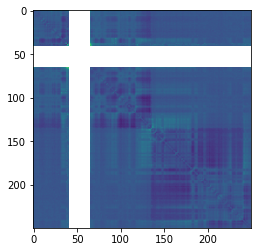

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(outputs['experiments'][0][0])

In [8]:
#make predictions on test chromosomes 
import torch
with torch.no_grad():
    mallpreds = []
    malltargets = []
    malltargetnans = []
    mallstarts = []
    for chrm in ['chr9','chr10']:
        chrlen = [len for c, len in hg38.get_chr_lens() if c == chrm][0]
        for pos in np.arange(16000000, chrlen-16000000, 500000):
            print(pos)
            targets = [torch.FloatTensor(target_h1esc.get_feature_data(chrm,pos-16000000, pos+16000000)[None,:,:]),
                          torch.FloatTensor(target_hff.get_feature_data(chrm,pos-16000000, pos+16000000)[None,:,:])]


            sequence = hg38.get_encoding_from_coords(chrm, pos-16000000, pos+16000000)
            seqs = [torch.FloatTensor(sequence[None,:,:]), torch.FloatTensor(sequence[None,::-1,::-1].copy())]

            allpreds = []
            alltargets = []
            alltargetnans = []
            allstarts = []

            for iii, seq in enumerate(seqs):
                for ii, model in enumerate([h1esc, hff]):

                    target = targets[ii]
                    encoding1, encoding2, encoding4, encoding8, encoding16, encoding32 = model.net(model.net0(torch.Tensor(seq.float()).transpose(1,2).cuda()))

                    encodings = {1: encoding1, 2: encoding2, 4: encoding4, 8:encoding8, 16:encoding16, 32:encoding32}

                    def eval_step(level, encoding, start, coarse_pred=None):
                        distenc=torch.log(torch.FloatTensor(model.normmats[level][None,None,:,:]).cuda()).expand(seq.shape[0],1,250,250)
                        if coarse_pred is not None:
                            if level == 1:
                                pred = model.denets[level].forward(encoding[:,:,int(start/level):int(start/level)+250], distenc, coarse_pred) + model.denet_1_pt.forward(encoding[:,:,int(start/level):int(start/level)+250])
                            else:
                                pred = model.denets[level].forward(encoding[:,:,int(start/level):int(start/level)+250], distenc, coarse_pred)
                        else:
                            pred = model.denets[level].forward(encoding[:,:,int(start/level):int(start/level)+250], distenc)


                        return pred

                    def t_step(level, start):
                        target_r = np.nanmean(np.nanmean(np.reshape(target[:,start:start+250*level,start:start+250*level].numpy(),(target.shape[0],250,level,250,level)),axis=4),axis=2)
                        target_np = np.log((target_r+model.epss[level])/(model.normmats[level]+model.epss[level]))[:,0:,0:].reshape((target_r.shape[0],-1))
                        target_nan = np.mean(np.mean(np.isnan(np.reshape(target[:,start:start+250*level,start:start+250*level].numpy(),(target.shape[0],250,level,250,level))),axis=4),axis=2)
                        return target_np, target_nan

                    start32 = 0
                    pred32 = eval_step(32, encodings[32], start32)
                    target32, target32nan = t_step(32, start32)
                    start16 = start32+(62+iii)*32
                    pred16 = eval_step(16, encodings[16], start16, pred32[:,:,(62+iii):(187+iii),(62+iii):(187+iii)].detach())
                    target16, target16nan = t_step(16, start16)
                    start8 = start16+(62+iii)*16
                    pred8 = eval_step(8, encodings[8], start8, pred16[:,:,(62+iii):(187+iii),(62+iii):(187+iii)].detach())
                    target8, target8nan = t_step(8, start8)
                    start4 = start8+(62+iii)*8
                    pred4 = eval_step(4, encodings[4], start4, pred8[:,:,(62+iii):(187+iii),(62+iii):(187+iii)].detach())
                    target4, target4nan = t_step(4, start4)
                    start2 = start4+(62+iii)*4
                    pred2 = eval_step(2, encodings[2], start2, pred4[:,:,(62+iii):(187+iii),(62+iii):(187+iii)].detach())
                    target2, target2nan = t_step(2, start2)
                    start1 = start2+(62+iii)*2
                    pred1 = eval_step(1, encodings[1], start1, pred2[:,:,(62+iii):(187+iii),(62+iii):(187+iii)].detach())
                    target1, target1nan = t_step(1, start1)

                    allpreds.append([pred1, pred2, pred4, pred8, pred16, pred32])
                    alltargets.append([target1, target2, target4, target8, target16, target32])
                    alltargetnans.append([target1nan, target2nan, target4nan, target8nan, target16nan, target32nan])
                    allstarts.append([start1, start2, start4, start8, start16, start32 ])
            mallpreds.append(allpreds)
            malltargets.append(alltargets)
            malltargetnans.append(alltargetnans)
            mallstarts.append(allstarts)

16000000


<PYTHONPATH>/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


16500000
17000000
17500000
18000000
18500000
19000000
19500000
20000000
20500000
21000000
21500000
22000000
22500000
23000000
23500000
24000000
24500000
25000000
25500000
26000000
26500000
27000000
27500000
28000000
28500000
29000000
29500000
30000000
30500000
31000000
31500000
32000000
32500000
33000000
33500000
34000000
34500000
35000000
35500000
36000000
36500000
37000000
37500000
38000000
38500000
39000000
39500000
40000000
40500000
41000000
41500000
42000000
42500000
43000000
43500000
44000000
44500000
45000000
45500000
46000000
46500000
47000000
47500000
48000000
48500000
49000000
49500000
50000000
50500000
51000000
51500000
52000000
52500000
53000000
53500000
54000000
54500000
55000000
55500000
56000000
56500000
57000000
57500000
58000000
58500000
59000000
59500000
60000000
60500000
61000000
61500000
62000000
62500000
63000000
63500000
64000000
64500000
65000000
65500000
66000000
66500000
67000000
67500000
68000000
68500000
69000000
69500000
70000000
70500000
71000000
71500000
7

In [11]:
torch.save(malltargets, './figure_data/malltargets.pth')
torch.save(malltargetnans, './figure_data/malltargetnans.pth')
torch.save(mallpreds, './figure_data/mallpreds.pth')
torch.save(mallstarts, './figure_data/mallstarts.pth')

In [ ]:
## optionally, load precomputed results

#import torch
#malltargets = torch.load('./figure_data/malltargets.pth')
#malltargetnans = torch.load('./figure_data/malltargetnans.pth')
#mallstarts = torch.load('./figure_data/mallstarts.pth')
#mallns = torch.load('./figure_data/mallns.pth')

In [12]:
from scipy.stats import pearsonr, spearmanr
from collections import defaultdict
import numpy as np


p1s = defaultdict(list)
p2s = defaultdict(list)
t1s = defaultdict(list)
t2s = defaultdict(list)

levelsn = [1,2,4,8,16,32]

for i in range(len(mallpreds)):
    for j in range(6):
        p1 = mallpreds[i][0][j].detach().cpu().numpy()[0,0,:,:][:,:].flatten()+mallpreds[i][2][j].detach().cpu().numpy()[0,0,::-1,::-1][:,:].flatten()
        t1 = malltargets[i][0][j][0,:].reshape((250,250))[:,:].flatten()
        p2 = mallpreds[i][1][j].detach().cpu().numpy()[0,0,:,:][:,:].flatten()+mallpreds[i][3][j].detach().cpu().numpy()[0,0,::-1,::-1][:,:].flatten()
        t2 = malltargets[i][1][j][0,:].reshape((250,250))[:,:].flatten()
        tn1 = malltargetnans[i][0][j][0,:].reshape((250,250))[:,:].flatten()
        tn2 = malltargetnans[i][1][j][0,:].reshape((250,250))[:,:].flatten()

        valid = np.isfinite(t1) * np.isfinite(t2) * (tn1<=0.25) * (tn2<=0.25)
        p1[~valid]=np.nan
        t1[~valid]=np.nan
        p1s[j].append(p1)
        t1s[j].append(t1)

        p2[~valid]=np.nan
        t2[~valid]=np.nan
        p2s[j].append(p2)
        t2s[j].append(t2)


In [13]:
#Performance

print('H1esc:')

for i in range(6):
    valid = np.isfinite(t1s[i])
    print(pearsonr(np.array(p1s[i])[valid], np.array(t1s[i])[valid])[0])
    

print('Hff:')

for i in range(6):
    valid = np.isfinite(t2s[i])
    print(pearsonr(np.array(p2s[i])[valid], np.array(t2s[i])[valid])[0])
     

print('Diff:')

for i in range(6):
    valid = np.isfinite(t2s[i])
    print(pearsonr(np.array(p2s[i])[valid]-np.array(p1s[i])[valid], np.array(t2s[i])[valid]-np.array(t1s[i])[valid])[0])

H1esc:
0.780286108723146
0.8109210008656892
0.8232399398437681
0.81830634969064
0.8137295206446905
0.8183362573721472
Hff:
0.7475666153774503
0.7786439457016664
0.7870375093379873
0.773384980622128
0.7577502861820424
0.7522835263820145
Diff:
0.2835263912851073
0.30784534614470743
0.33583317023713005
0.3597493789006473
0.4124063755316293
0.47209534190544994


In [14]:
from plotnine import *
import pandas as pd
import plotnine
plotnine.options.figure_size = (8, 6)


np.random.seed(0)
levels = ['1Mb','2Mb','4Mb','8Mb','16Mb','32Mb'] 
plotdata = []
for i in range(6):
    valid = np.isfinite(t1s[i]) * np.isfinite(t2s[i])
    subsetind = np.random.permutation(np.sum(valid))[:100000]
    plotdata.append(pd.DataFrame({'x':np.array(p1s[i])[valid][subsetind], 'y':np.array(t1s[i])[valid][subsetind], \
                                  'level': levels[i], 'cell': 'H1-ESC'}))
    plotdata.append(pd.DataFrame({'x':np.array(p2s[i])[valid][subsetind], 'y':np.array(t2s[i])[valid][subsetind], \
                                  'level': levels[i], 'cell': 'HFF'}))
    
plotdata = pd.concat(plotdata, axis=0)
plotdata['level'] = pd.Categorical(plotdata['level'], levels)

plotdata.to_csv('./figure_data/predeval.32m.csv')

In [15]:
import pandas as pd
plotdata = pd.read_csv('./figure_data/predeval.32m.csv')
plotdata2 = pd.read_csv('./figure_data/predeval.256m.csv')
plotdata = pd.concat([plotdata, plotdata2], axis=0)
plotdata['level'] = pd.Categorical(plotdata['level'], \
                                   ['1Mb','2Mb','4Mb','8Mb','16Mb','32Mb','64Mb','128Mb','256Mb'] )
plotdata_inter = pd.read_csv('./figure_data/predeval.256m.crosschrom.inter.csv')

plotdata2=[]
for level in ['1Mb','2Mb','4Mb','8Mb','16Mb','32Mb','64Mb','128Mb','256Mb']:
    x = plotdata[(plotdata['level']==level )*(plotdata['cell']=='H1-ESC' )]
    x0 = plotdata[(plotdata['level']==level )*(plotdata['cell']=='HFF' )]
    plotdata2.append(pd.DataFrame({'x':x['x'].values-x0['x'], 'y':x['y'].values-x0['y'].values, \
                                  'level': level, 'cell': 'H1-ESC vs HFF'}))
plotdata2 = pd.concat(plotdata2, axis=0)
plotdata2['level'] = pd.Categorical(plotdata2['level'], \
                                   ['1Mb','2Mb','4Mb','8Mb','16Mb','32Mb','64Mb','128Mb','256Mb'] )

#use a subset for plotting
plotdata_sub = plotdata.iloc[np.arange(0,plotdata.shape[0],10),:]
plotdata_intersub = plotdata_inter.iloc[np.arange(0,plotdata_inter.shape[0],10),:]
plotdata_intersub['level'] = pd.Categorical(plotdata_intersub['level'], \
                                   ['32Mb','64Mb','128Mb','256Mb'] )

<PYTHONPATH>/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
<PYTHONPATH>/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
%load_ext rpy2.ipython

  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang





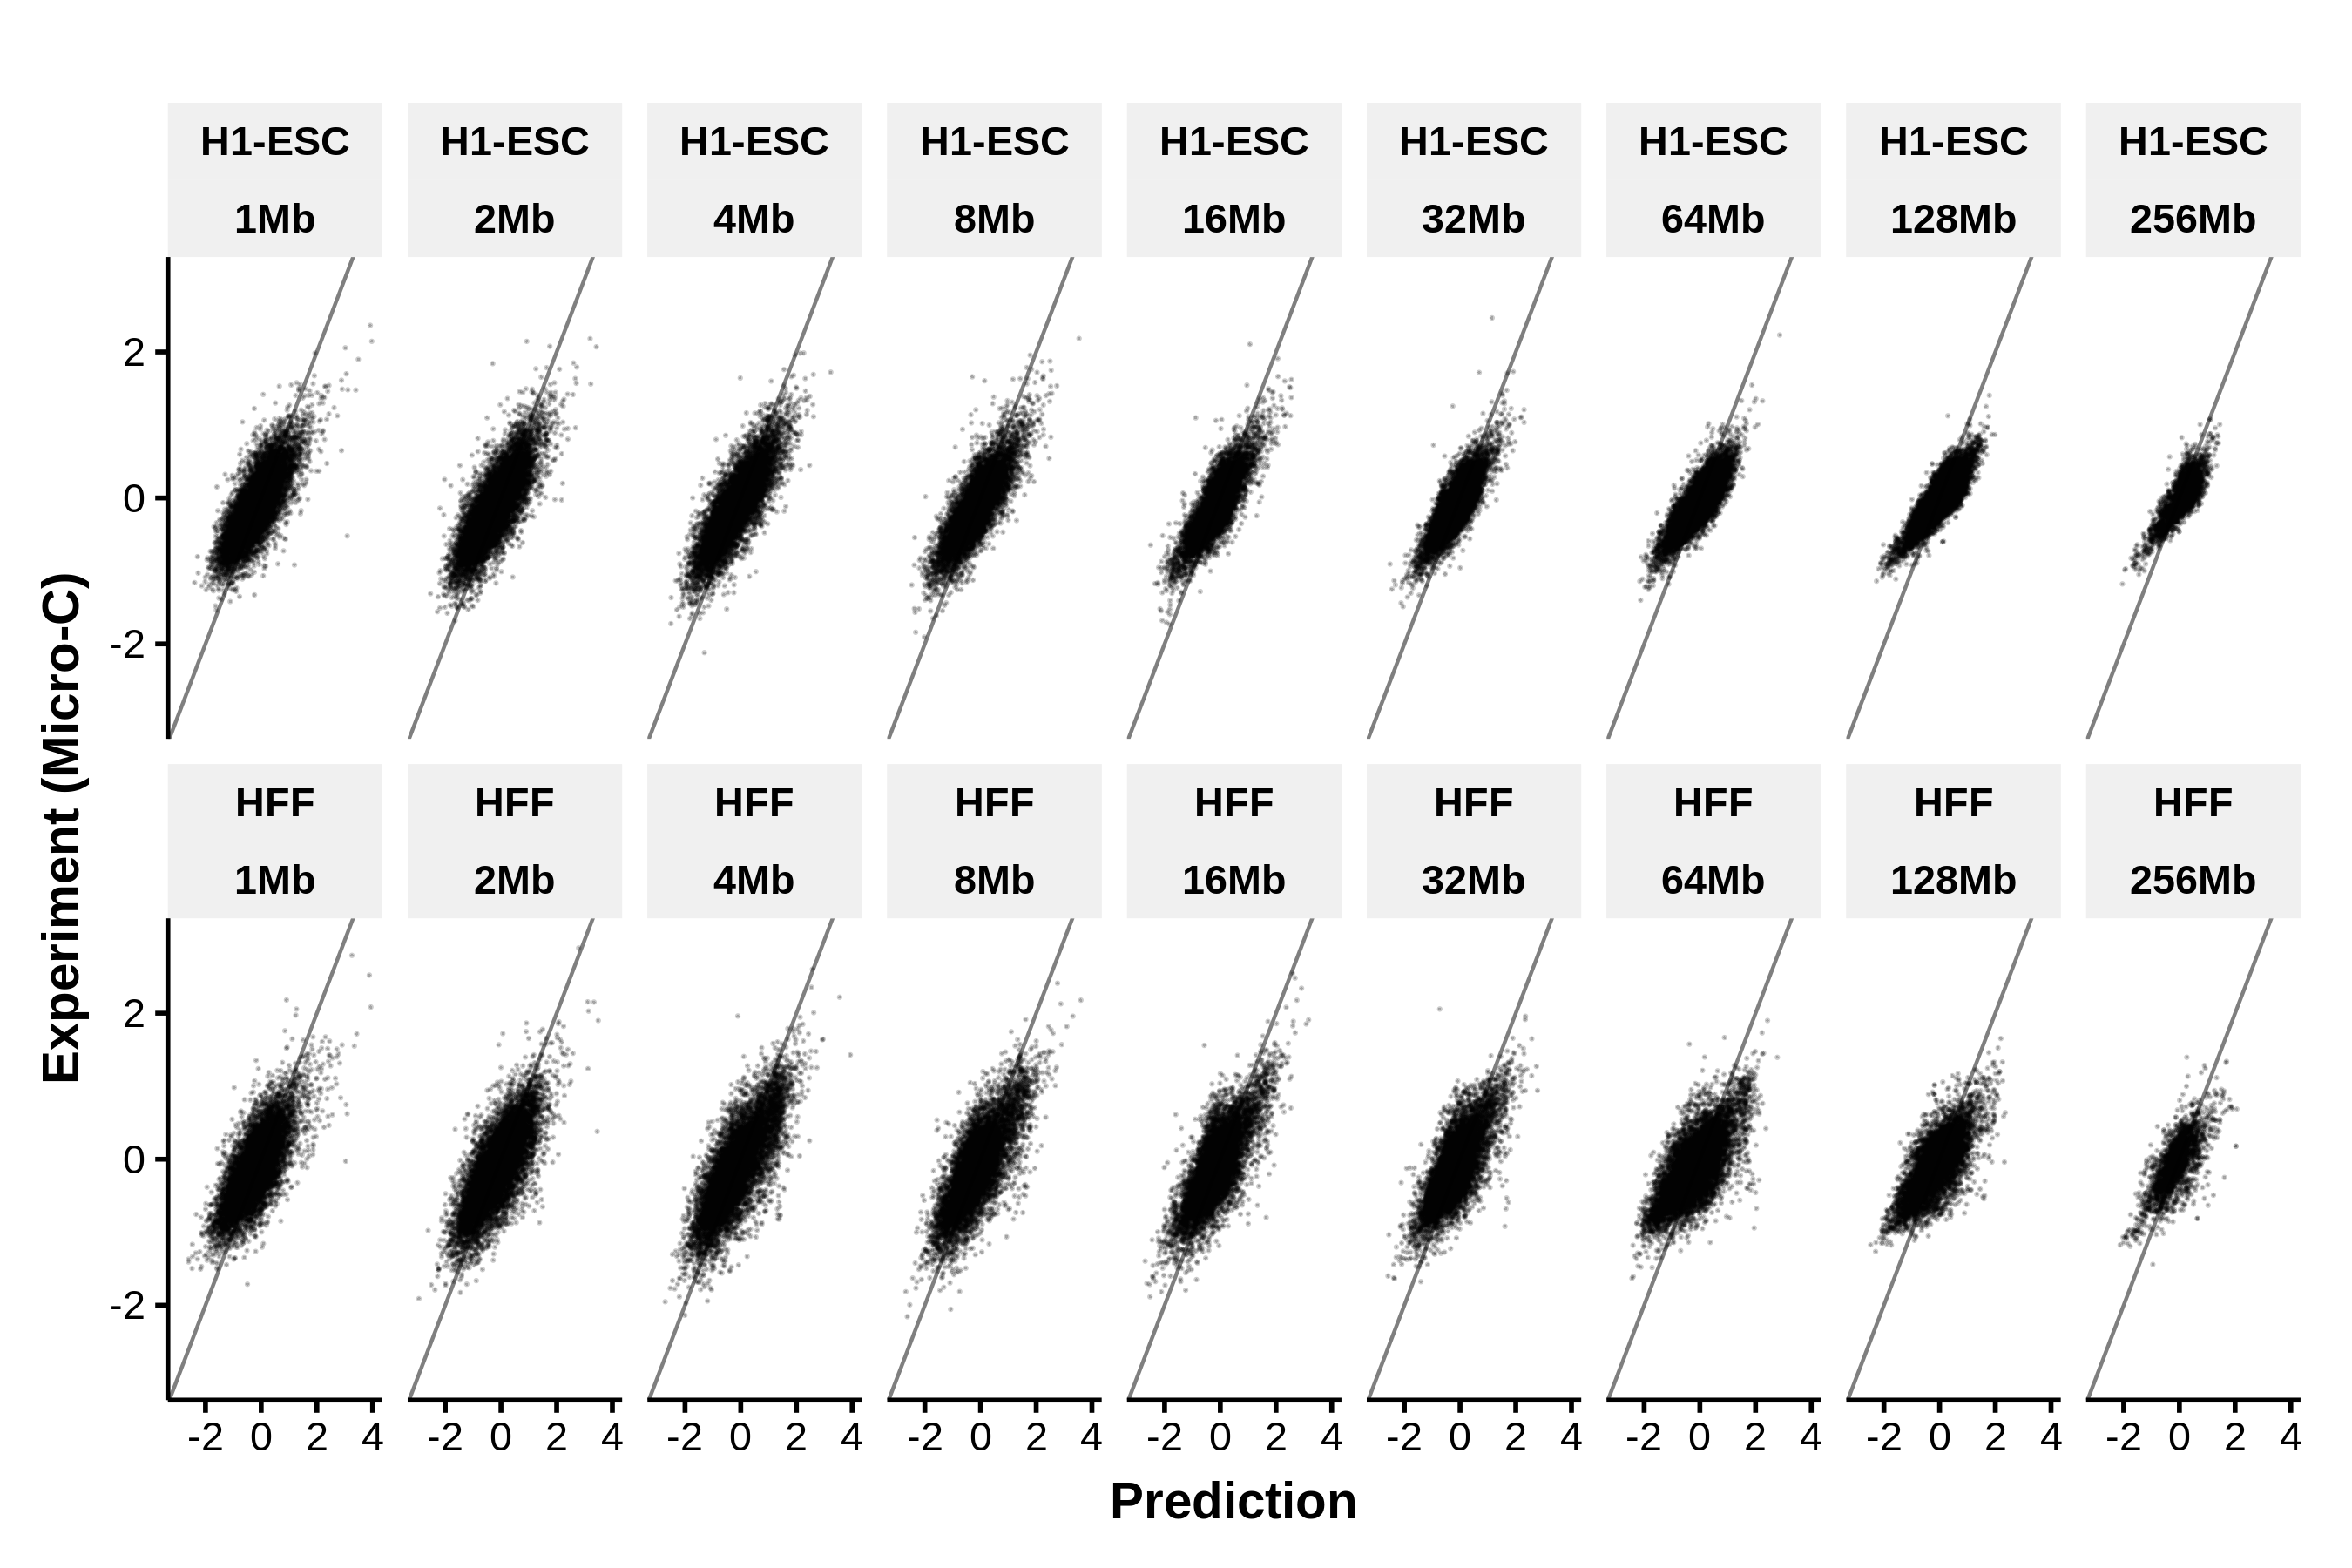

In [17]:
%%R -i plotdata_sub -w 9 -h 6 --units in -r 300
#scatter plot visualization of predictions
library(ggrastr)
require(ggplot2)
theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_blank(),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(0.2, "cm"),
               legend.margin = unit(0, "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}
p = ggplot(plotdata_sub)+geom_point(aes(x=x,y=y),size=I(0.05),alpha=0.2)+theme_minimal()+
    geom_abline(slope=1,alpha=0.5)+xlab('Prediction')+ylab('Experiment (Micro-C)')+ ylim(-3,3)+ xlim(-3,4)+
        facet_wrap(cell ~ level,ncol=9)+theme_Publication()

ggsave('./figures/perf.pdf',device=cairo_pdf,dpi=600)
p

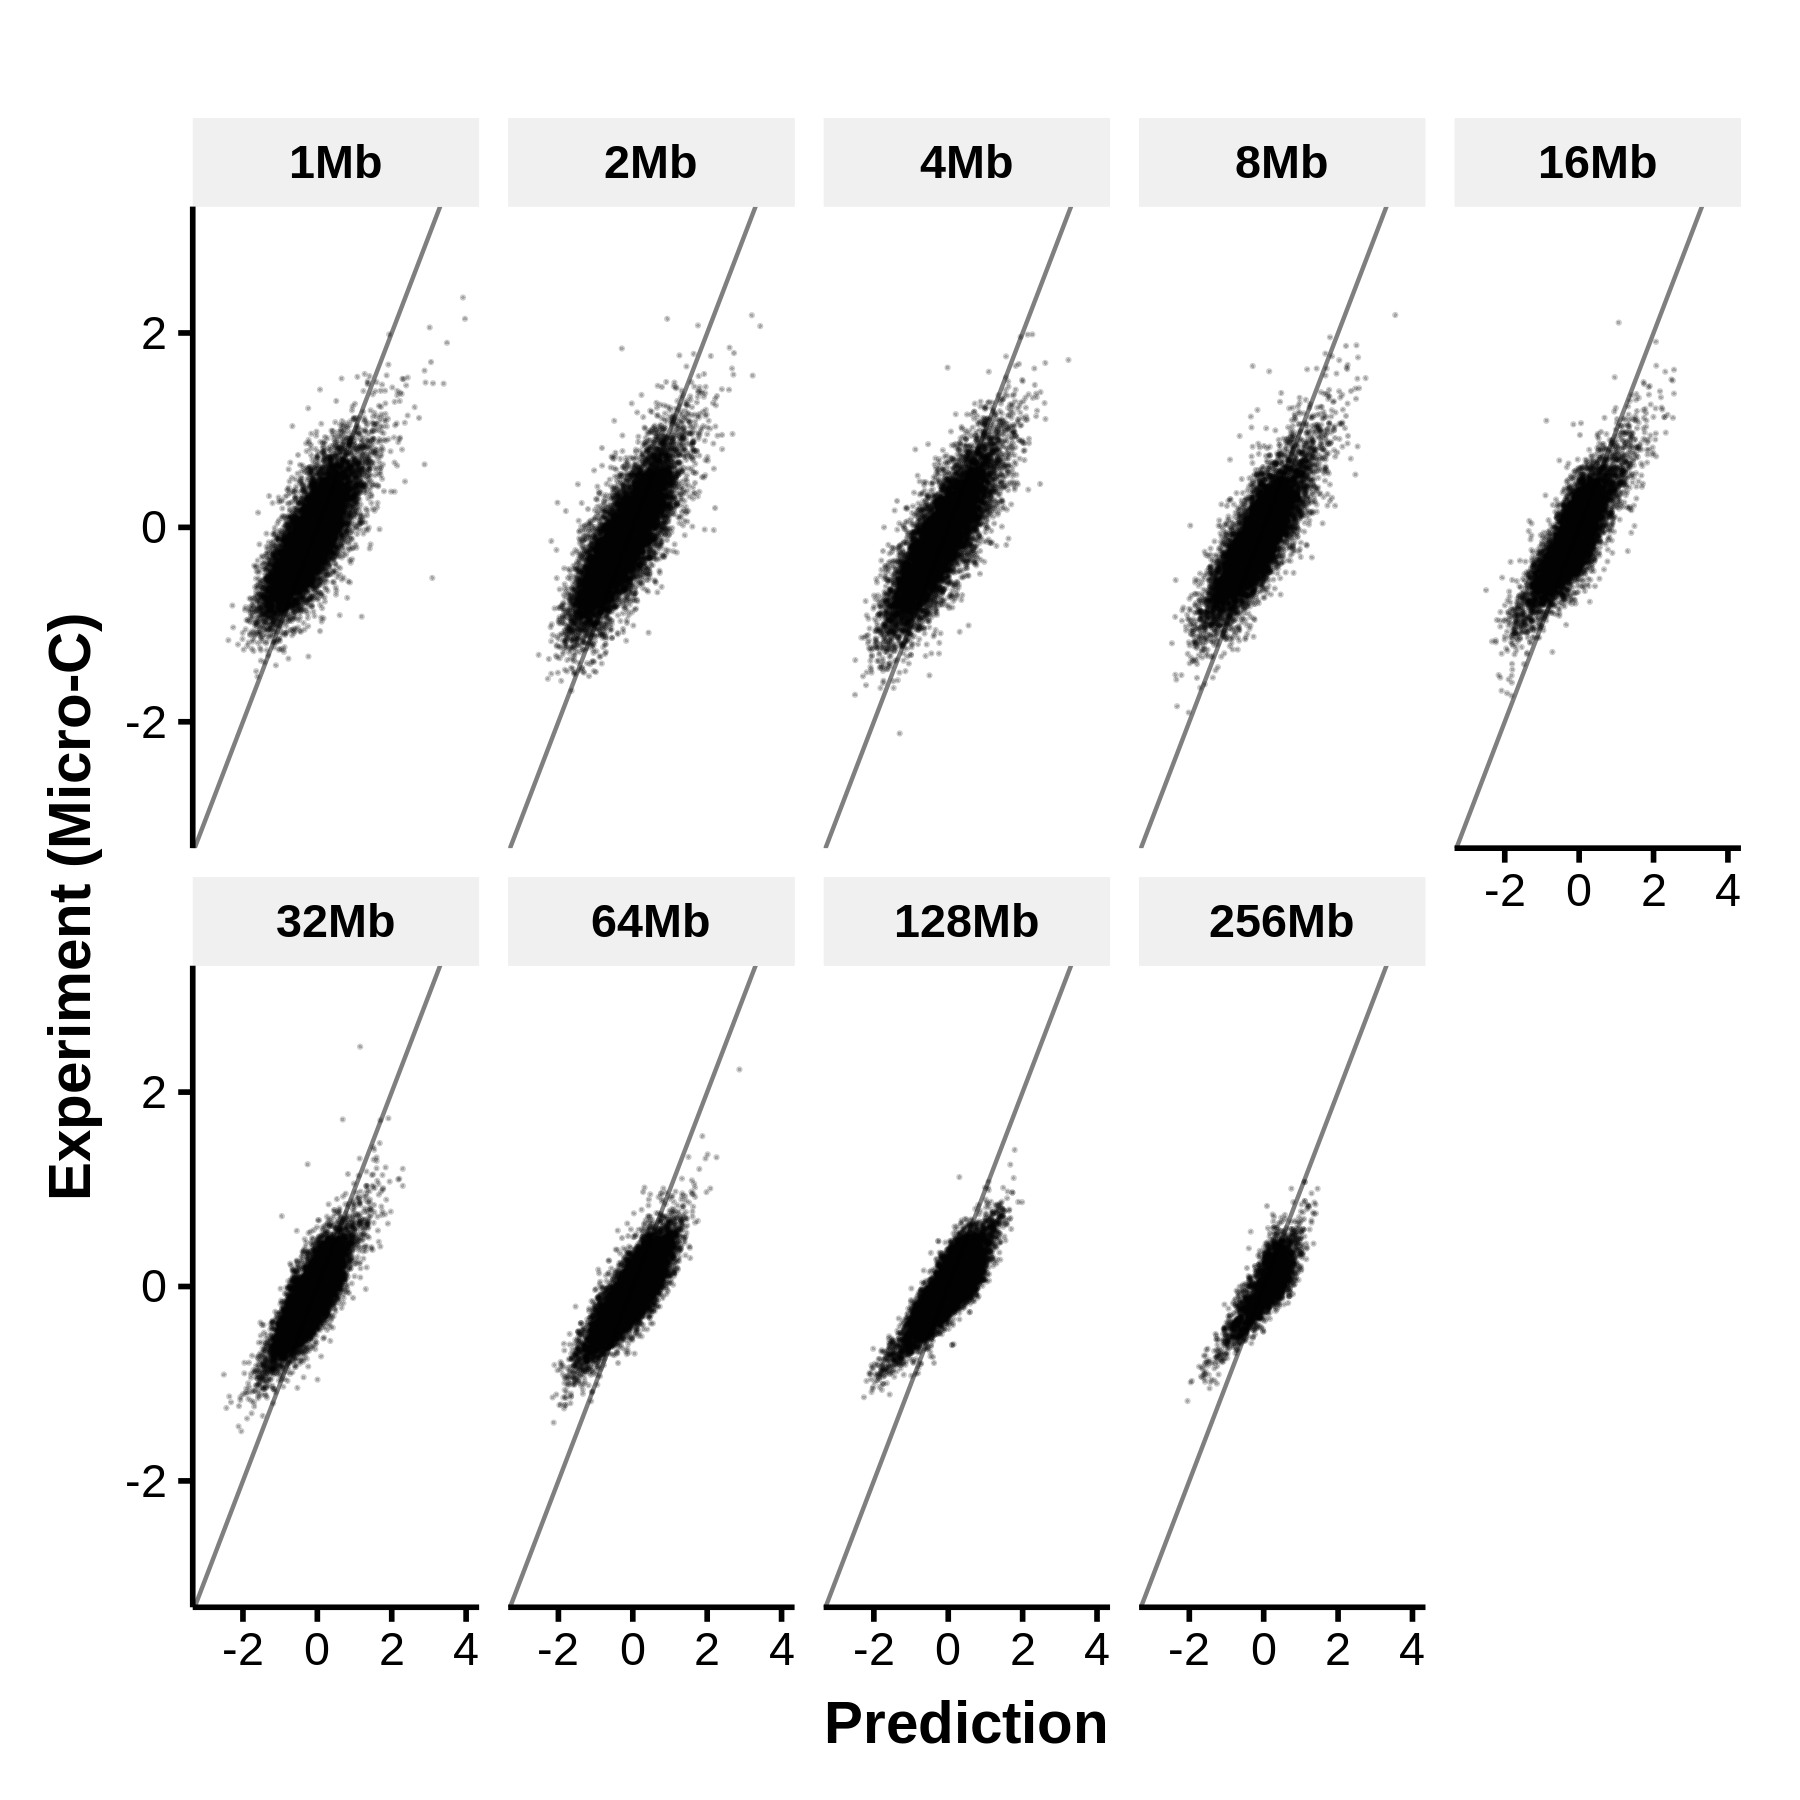

In [18]:
%%R -i plotdata_sub -w 6 -h 6 --units in -r 300
#scatter plot visualization of predictions for H1-ESC only (for Figure 1 panel)


library(ggrastr)
require(ggplot2)
theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_blank(),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(0.2, "cm"),
               legend.margin = unit(0, "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}

#p = ggplot(plotdata_sub[plotdata_sub$cell=='H1-ESC',])+rasterise(geom_point(aes(x=x,y=y),size=I(0.5),alpha=0.1),dpi=1000)+theme_minimal()+
#    geom_abline(slope=1,alpha=0.5)+xlab('Prediction')+ylab('Experiment (Micro-C)')+ ylim(-3,3)+ xlim(-3,4)+
#        facet_wrap(cell ~ level,ncol=5)+theme_Publication()
p = ggplot(plotdata_sub[plotdata_sub$cell=='H1-ESC',])+geom_point(aes(x=x,y=y),size=I(0.05),alpha=0.2)+theme_minimal()+
    geom_abline(slope=1,alpha=0.5)+xlab('Prediction')+ylab('Experiment (Micro-C)')+ ylim(-3,3)+ xlim(-3,4)+
        facet_wrap(. ~ level,ncol=5)+theme_Publication()

ggsave('./figures/perf.h1esc.pdf',device=cairo_pdf,dpi=1000)
p

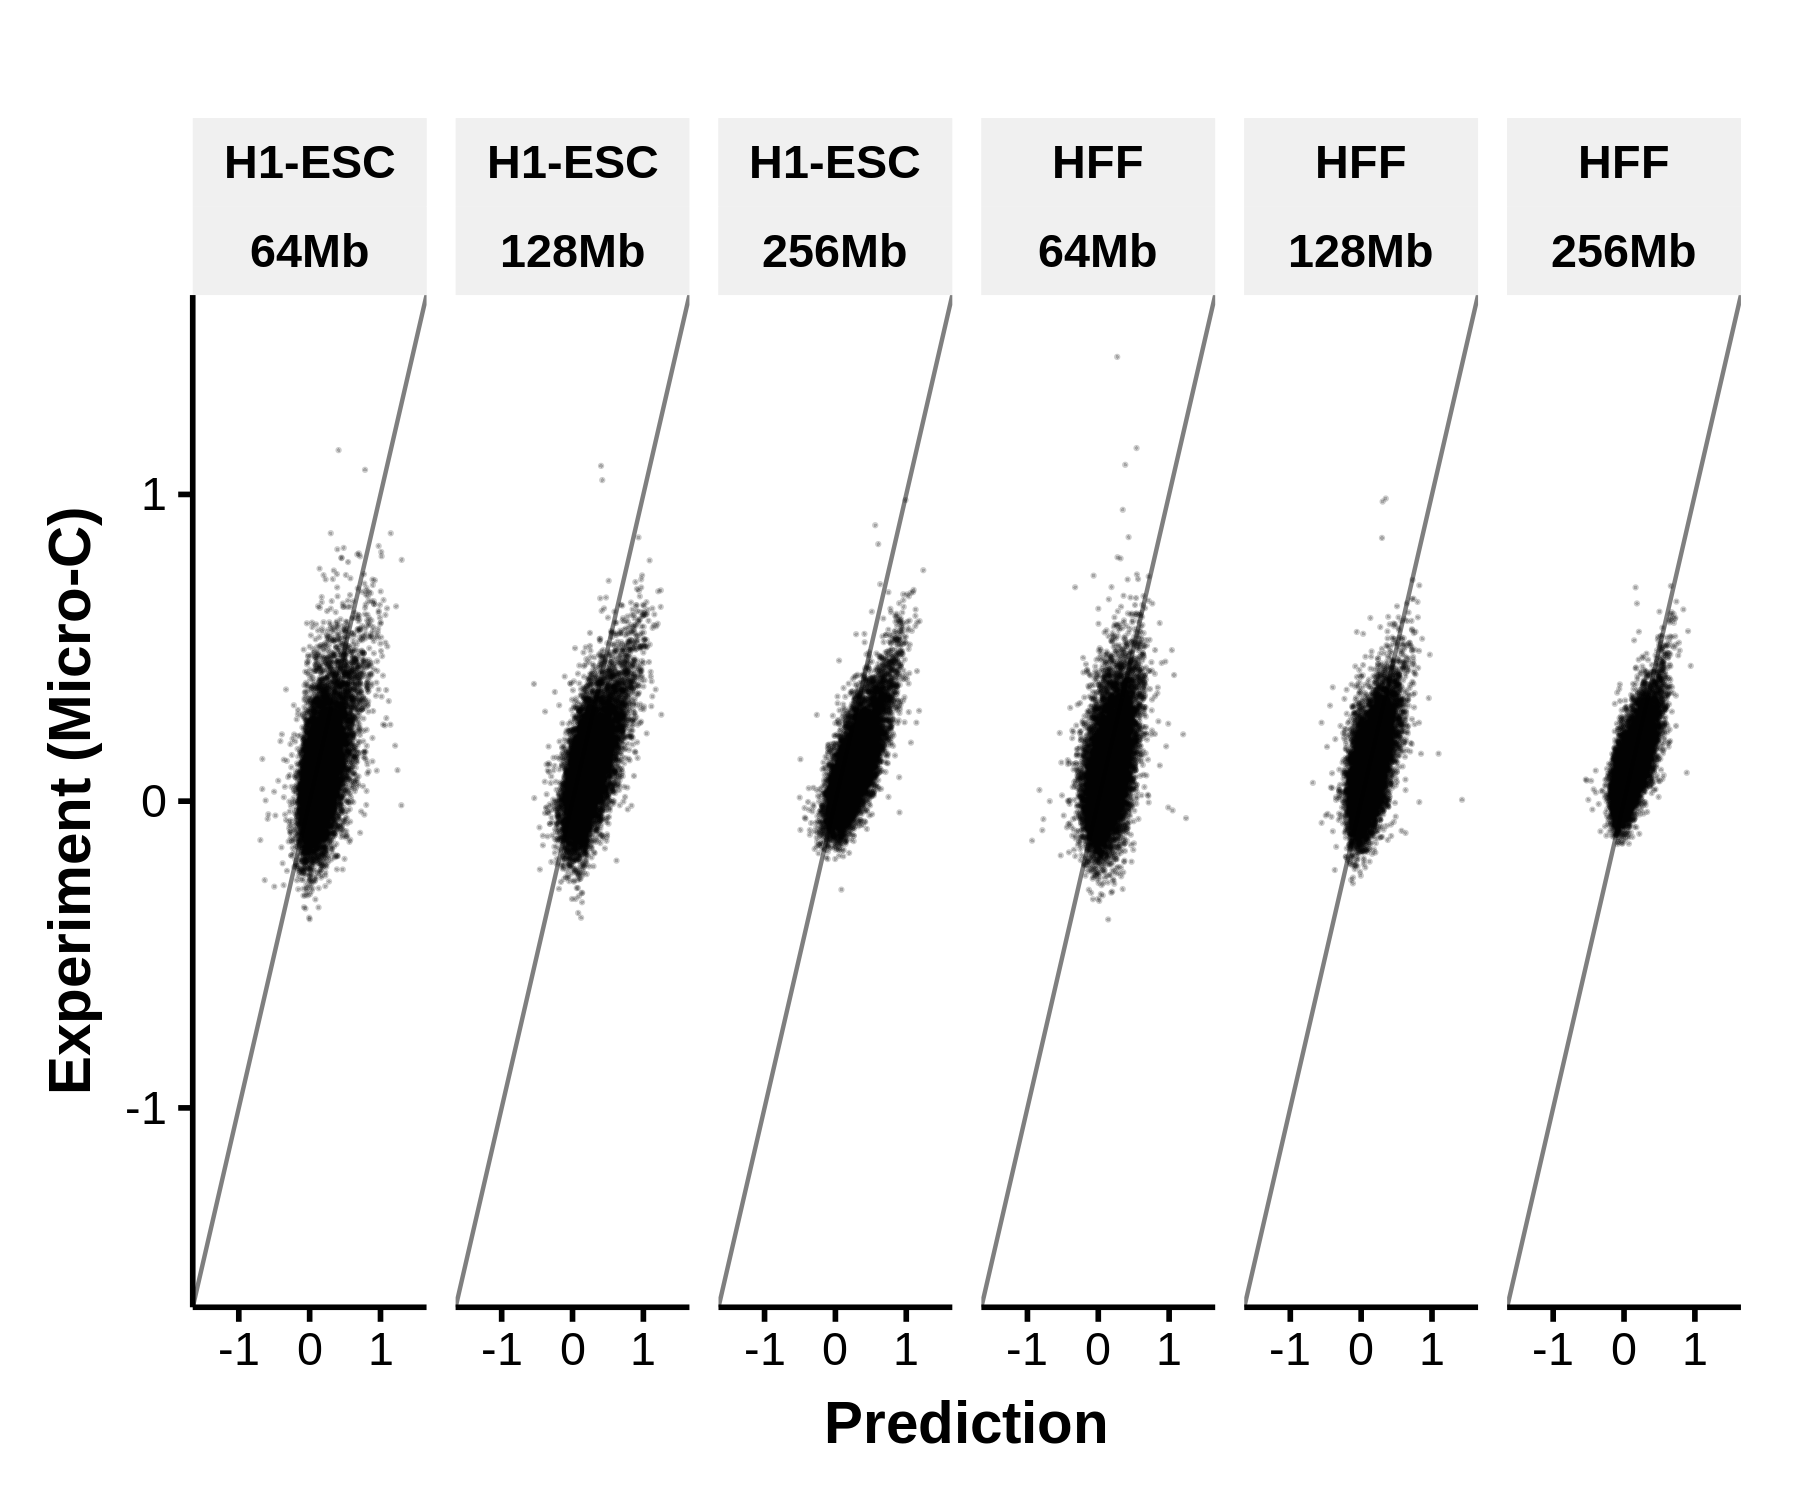

In [19]:
%%R -i plotdata_sub,plotdata_intersub -w 6 -h 5 --units in -r 300
##scatter plot visualization of interchromosomal predictions (both chromosomes are in test set)
 
library(ggrastr)
require(ggplot2)
require(data.table)
require(patchwork)
theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_blank(),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(0.2, "cm"),
               legend.margin = unit(0, "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}
plotdata_sub =data.table(plotdata_sub)
plotdata_intersub =data.table(plotdata_intersub)
p = ggplot(plotdata_intersub[level %in% c('64Mb','128Mb','256Mb'),])+geom_point(aes(x=x,y=y),size=I(0.05),alpha=0.2)+theme_minimal()+
    geom_abline(slope=1,alpha=0.5)+xlab('Prediction')+ylab('Experiment (Micro-C)')+ scale_x_continuous(limits=c(-1.5,1.5))+ 
    scale_y_continuous(limits=c(-1.5,1.5))+facet_wrap(cell ~ level,ncol=8)+theme_Publication()
ggsave('./figures/perf.inter.pdf',device=cairo_pdf,dpi=1000)
p

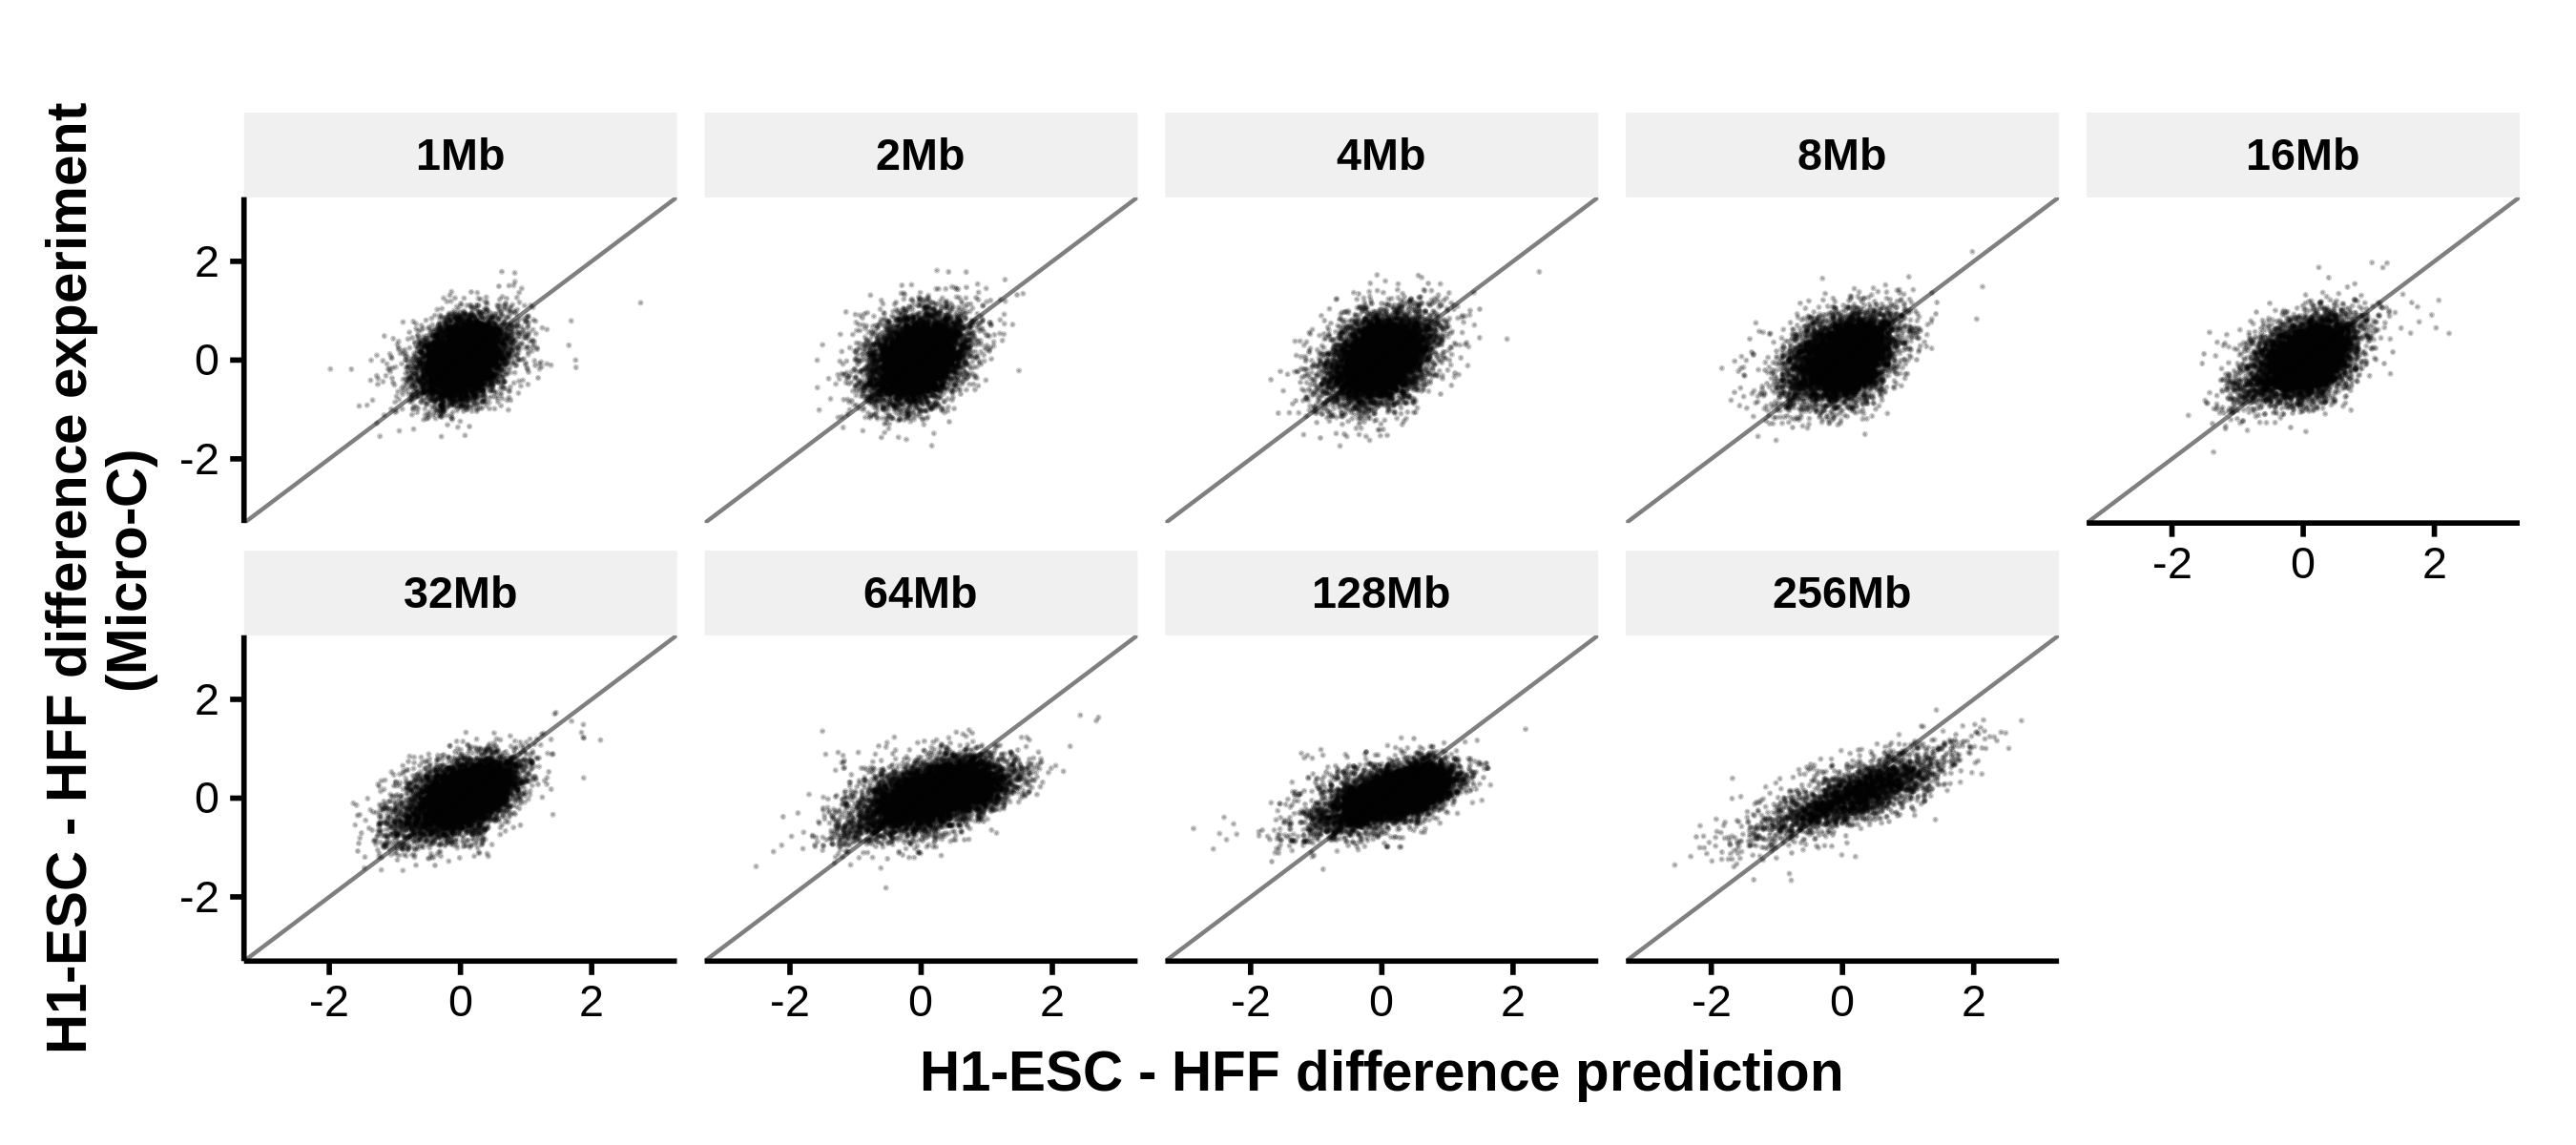

In [20]:
%%R -i plotdata_sub -w 9 -h 4 --units in -r 300
##scatter plot visualization of cross-cell-type difference predictions 

require(ggplot2)
require(data.table)
theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_blank(),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(0.2, "cm"),
               legend.margin = unit(0, "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}
plotdata_sub = data.table(plotdata_sub)
plotdata_sub_diff = data.frame(x = plotdata_sub[cell=='H1-ESC', x] - plotdata_sub[cell=='HFF', x],
           y = plotdata_sub[cell=='H1-ESC', y] - plotdata_sub[cell=='HFF', y],
           level =  plotdata_sub[cell=='H1-ESC', level])


p = ggplot(plotdata_sub_diff)+geom_point(aes(x=x,y=y),size=I(0.05),alpha=0.2)+theme_minimal()+
    geom_abline(slope=1,alpha=0.5)+xlab('H1-ESC - HFF difference prediction')+ylab('H1-ESC - HFF difference experiment\n (Micro-C)')+ ylim(-3,3)+ xlim(-3,3)+
        facet_wrap(. ~ level,ncol=5)+theme_Publication()

ggsave('./figures/perf.diff.pdf',device=cairo_pdf)
p

In [21]:
#AUROC for cross cell type difference prediction for sites with strongest difference between cell types (top 1 percentile)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import pandas as pd
levels = ['1Mb','2Mb','4Mb','8Mb','16Mb','32Mb']
plotdata = []
for i in range(6):
    valid = np.isfinite(t2s[i])
    thresh = np.quantile(np.abs(np.array(t2s[i])-np.array(t1s[i]))[valid], 0.99)
    valid = valid * (np.abs(np.array(t2s[i])-np.array(t1s[i]))> thresh)
    
    print(roc_auc_score(
                 (np.array(t2s[i])[valid]-np.array(t1s[i])[valid])>0,
                 np.array(p2s[i])[valid] - np.array(p1s[i])[valid]))
    fpr, tpr, _ = roc_curve(
                 (np.array(t2s[i])[valid]-np.array(t1s[i])[valid])>0,
                 np.array(p2s[i])[valid] - np.array(p1s[i])[valid])
    plotdata.append(pd.DataFrame({'FPR':fpr,'TPR':tpr,'level':levels[i]}))
plotdata=pd.concat(plotdata, axis=0)
plotdata.to_csv('./figure_data/predeval.roc.32m.csv')


<PYTHONPATH>/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


0.8503066512009267


<PYTHONPATH>/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


0.858291079111169


<PYTHONPATH>/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


0.8817831216467527


<PYTHONPATH>/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


0.9097002527024954


<PYTHONPATH>/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


0.9398737048873412


<PYTHONPATH>/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


0.9678040460872497


In [22]:
import pandas as pd
plotdata = pd.read_csv('./figure_data/predeval.roc.32m.csv')
plotdata2 = pd.read_csv('./figure_data/predeval.roc.256m.csv')
plotdata = pd.concat([plotdata, plotdata2], axis=0)
plotdata['level'] = pd.Categorical(plotdata['level'], \
                                   ['1Mb','2Mb','4Mb','8Mb','16Mb','32Mb','64Mb','128Mb','256Mb'] )


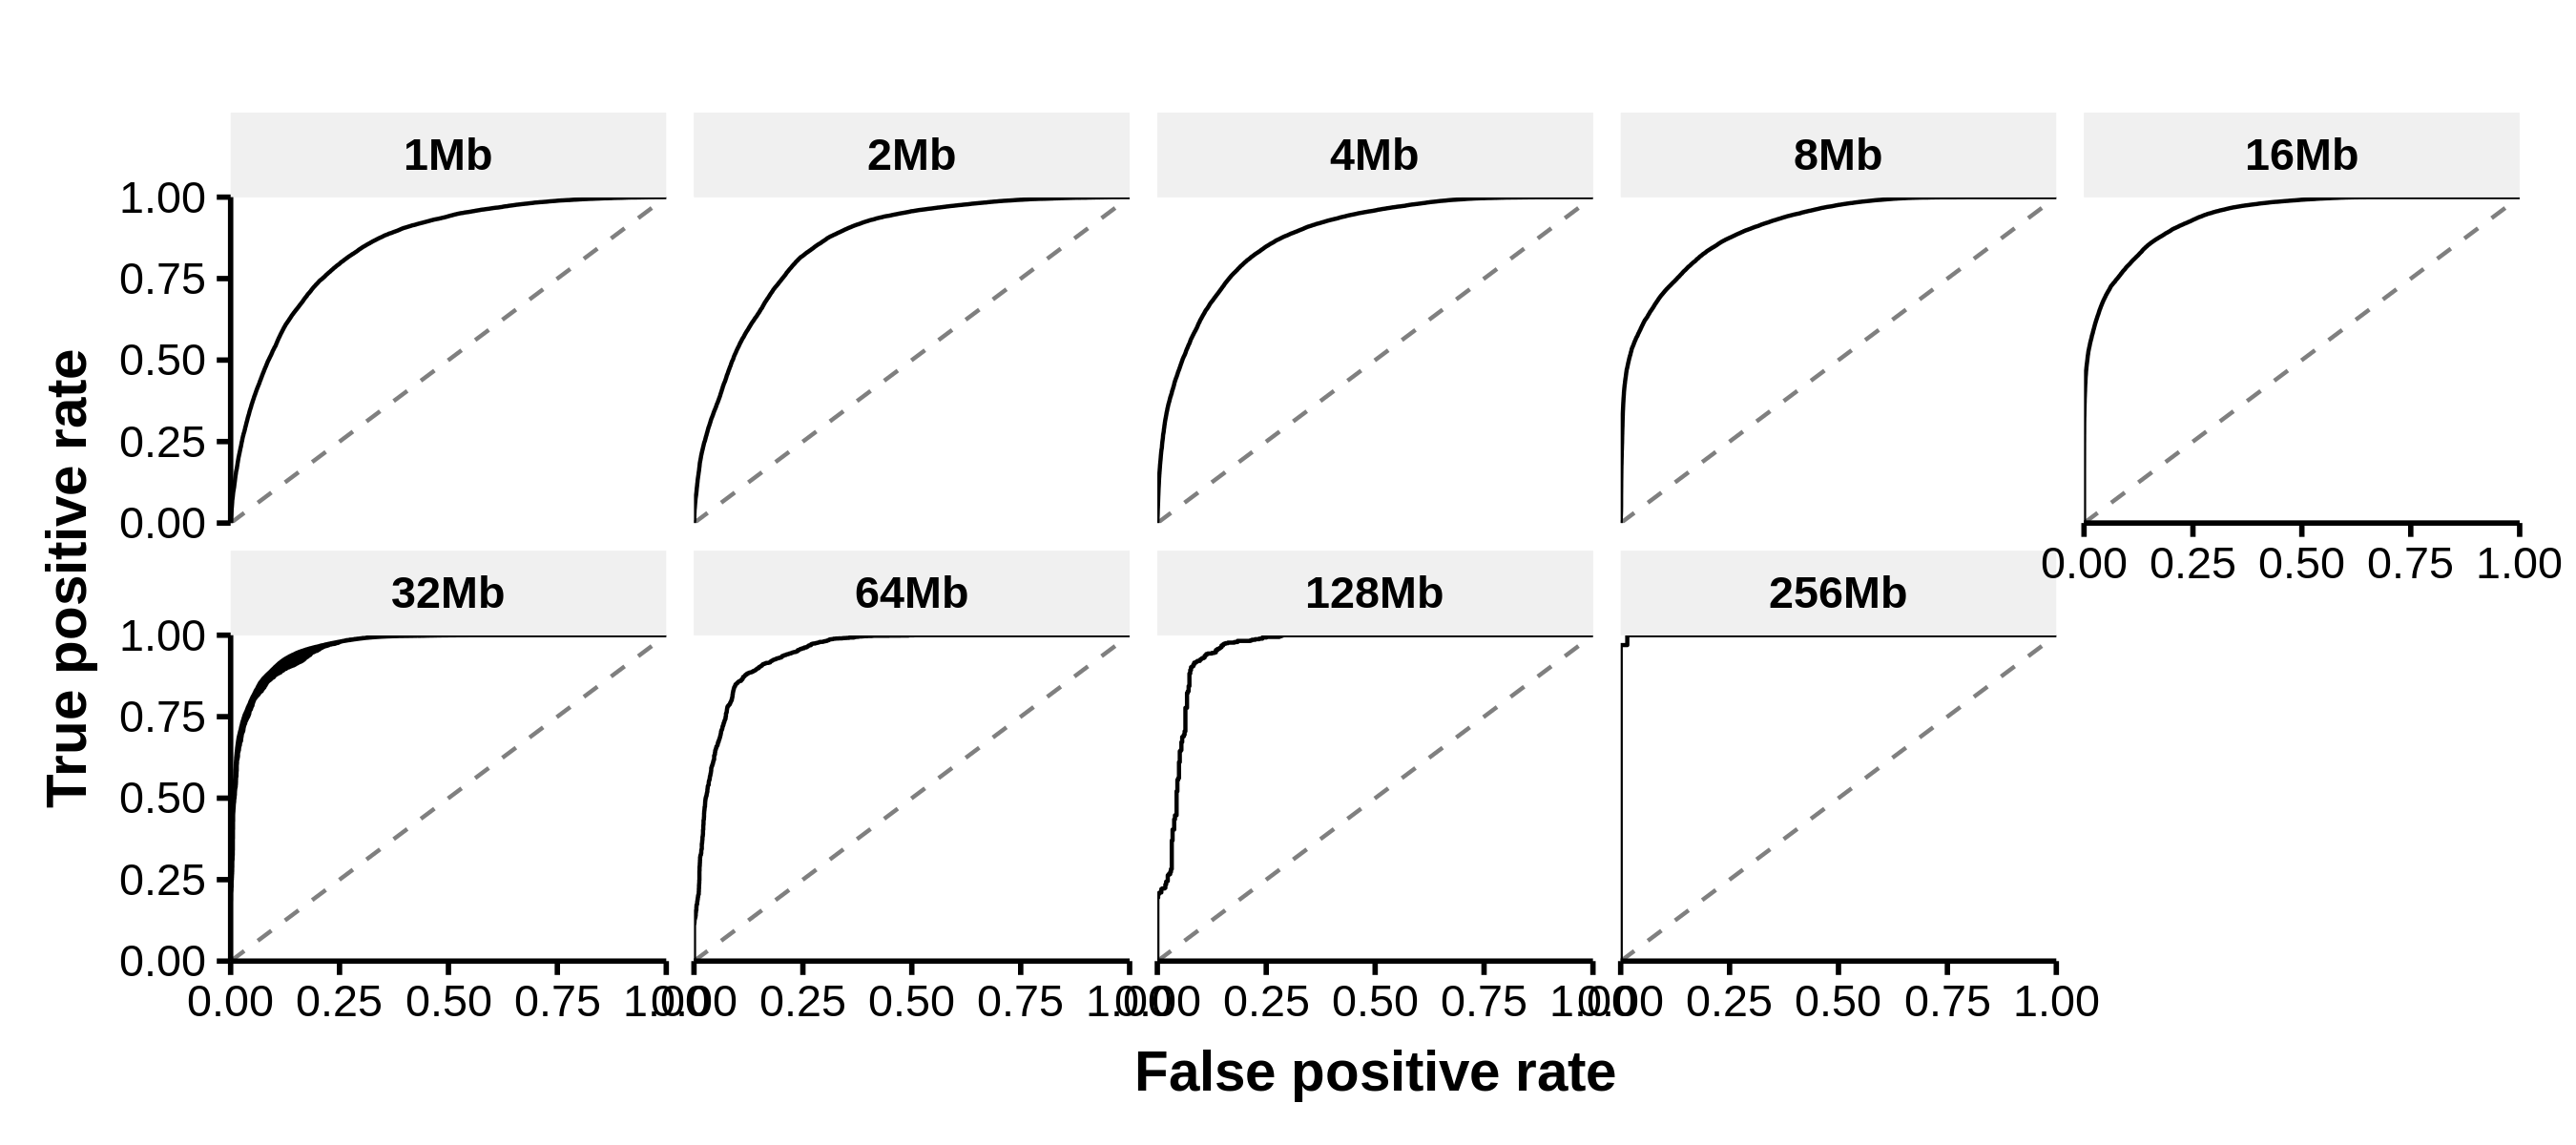

In [23]:
%%R -i plotdata -w 9 -h 4 --units in -r 300
#ROC plot for cross cell type difference prediction 
library(ggrastr)
require(ggplot2)
require(data.table)
theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_blank(),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(0.2, "cm"),
               legend.margin = unit(0, "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}
plotdata = data.table(plotdata)


p = ggplot(plotdata)+geom_line(aes(x=FPR,y=TPR))+theme_minimal()+
    geom_abline(slope=1,linetype=2,alpha=0.5)+xlab('False positive rate')+ylab('True positive rate')+
        scale_x_continuous(expand = c(0, 0)) + scale_y_continuous(expand = c(0, 0))+
        facet_wrap(. ~ level,ncol=5)+theme_Publication()

ggsave('./figures/perf.diff.roc.pdf',device=cairo_pdf)
p

In [24]:
#load chromatin tracks data
import torch
import pyBigWig

bwlist = [ORCA_PATH+'/extra/H1_CTCF_ENCFF473IZV.bigWig', 
          ORCA_PATH+'/extra/H1_H3K4me3_ENCFF623ZAW.bigWig',
          ORCA_PATH+'/extra/H1_H3K27ac_ENCFF423TVA.bigWig',
          ORCA_PATH+'/extra/H1_H3K4me1_ENCFF584AVI.bigWig',
          ORCA_PATH+'/extra/H1_H3K27me3_ENCFF912ZUR.bigWig',
          ORCA_PATH+'/extra/foreskin_fibroblast_CTCF_ENCFF761RHS.bigWig',
          ORCA_PATH+'/extra/foreskin_fibroblast_H3K4me3_ENCFF442WNT.bigWig',
          ORCA_PATH+'/extra/foreskin_fibroblast_H3K27ac_ENCFF078JZB.bigWig',
          ORCA_PATH+'/extra/foreskin_fibroblast_H3K4me1_ENCFF449DEA.bigWig',
          ORCA_PATH+'/extra/foreskin_fibroblast_H3K27me3_ENCFF027GWJ.bigWig']

with torch.no_grad():
    mallbws = []
    for chrm in ['chr9','chr10']:
        chrlen = [len for c, len in hg38.get_chr_lens() if c == chrm][0]
        for pos in np.arange(16000000, chrlen-16000000, 500000):
            print(pos)
            bws = []
            for f in bwlist:
                bw = pyBigWig.open(f)
                b= np.array(bw.stats(chrm, pos-16000000, pos+16000000, nBins=8000, type="mean", exact=True))
            
            
                def t_step(level, start):
                    return np.mean(np.reshape(b[start:start+250*level],\
                                               (250,level)),axis=1)

                start32 = 0
                n32 = t_step(32, start32)
                start16 = start32+(62)*32
                n16 = t_step(16, start16)
                start8 = start16+(62)*16
                n8 = t_step(8, start8)
                start4 = start8+(62)*8
                n4 = t_step(4, start4)
                start2 = start4+(62)*4
                n2 = t_step(2, start2)
                start1 = start2+(62)*2
                n1 = t_step(1, start1)

                bws.append([n1, n2, n4, n8, n16, n32])
            mallbws.append(bws)
torch.save(mallbws,'./figure_data/mallbws.pth')



16000000
16500000
17000000
17500000
18000000
18500000
19000000
19500000
20000000
20500000
21000000
21500000
22000000
22500000
23000000
23500000
24000000
24500000
25000000
25500000
26000000
26500000
27000000
27500000
28000000
28500000
29000000
29500000
30000000
30500000
31000000
31500000
32000000
32500000
33000000
33500000
34000000
34500000
35000000
35500000
36000000
36500000
37000000
37500000
38000000
38500000
39000000
39500000
40000000
40500000
41000000
41500000
42000000
42500000
43000000
43500000
44000000
44500000
45000000
45500000
46000000
46500000
47000000
47500000
48000000
48500000
49000000
49500000
50000000
50500000
51000000
51500000
52000000
52500000
53000000
53500000
54000000
54500000
55000000
55500000
56000000
56500000
57000000
57500000
58000000
58500000
59000000
59500000
60000000
60500000
61000000
61500000
62000000
62500000
63000000
63500000
64000000
64500000
65000000
65500000
66000000
66500000
67000000
67500000
68000000
68500000
69000000
69500000
70000000
70500000
71000000
7

In [25]:
#mallbws = torch.load('./figure_data/mallbws.pth')

In [26]:
#Genome interaction prediction performance for different region types 
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import roc_auc_score
from collections import defaultdict
import numpy as np
mallbws = np.array(mallbws)
allbwthreshs = [ [np.percentile(mallbws[:,i,j,:].flatten(), 95) for i in range(10)] for j in range(6)]
allbwthresh90s = [ [np.percentile(mallbws[:,i,j,:].flatten(), 90) for i in range(10)] for j in range(6)]
tthreshs = [[],[]]
for k in range(2):
    for j in range(6):
        t = np.array([malltargets[i][k][j] for i in range(len(malltargets))]).flatten()
        tthreshs[k].append(np.percentile(t[np.isfinite(t)],90))
        
levelsn = [1,2,4,8,16,32]

ts = ['CTCF','H3K4me3','H3K27ac', 'H3K4me1', 'H3K27me3']

target_cells = []
predict_cells = []
filter_features = []
aucs = []
Ns = []
levels = []
for target_cell in ['H1-ESC','HFF']:
    for t in range(5):
        p1s = defaultdict(list)
        p2s = defaultdict(list)
        t1s = defaultdict(list)
        t2s = defaultdict(list)

        for i in range(len(mallpreds)):
            for j in range(6):

                    p1 = mallpreds[i][0][j].detach().cpu().numpy()[0,0,:,:][:,:].flatten()+mallpreds[i][2][j].detach().cpu().numpy()[0,0,::-1,::-1][:,:].flatten()
                    t1 = malltargets[i][0][j][0,:].reshape((250,250))[:,:].flatten()
                    p2 = mallpreds[i][1][j].detach().cpu().numpy()[0,0,:,:][:,:].flatten()+mallpreds[i][3][j].detach().cpu().numpy()[0,0,::-1,::-1][:,:].flatten()
                    t2 = malltargets[i][1][j][0,:].reshape((250,250))[:,:].flatten()
                    tn1 = malltargetnans[i][0][j][0,:].reshape((250,250))[:,:].flatten()
                    tn2 = malltargetnans[i][1][j][0,:].reshape((250,250))[:,:].flatten()

                    if target_cell == 'H1-ESC':
                        b = ( (mallbws[i][0][j][:,None]<allbwthresh90s[j][0]) * (mallbws[i][0][j][None,:]<allbwthresh90s[j][0])).flatten()
                        c = ( (mallbws[i][t][j][:,None]>allbwthreshs[j][t]) * (mallbws[i][t][j][None,:]>allbwthreshs[j][t])).flatten()
                        if t == 0:
                            filtered = ((t1>tthreshs[0][j]) * (~( c))) | ((t1<=tthreshs[0][j]) * ( c))
                        else:
                            filtered = ((t1>tthreshs[0][j]) * (~(b * c))) 
                    else:
                        b = ( (mallbws[i][0+5][j][:,None]<allbwthresh90s[j][0+5]) * (mallbws[i][0+5][j][None,:]<allbwthresh90s[j][0+5])).flatten()
                        c = ( (mallbws[i][t+5][j][:,None]>allbwthreshs[j][t+5]) * (mallbws[i][t+5][j][None,:]>allbwthreshs[j][t+5])).flatten()
                        if t == 0:
                            filtered = ((t2>tthreshs[1][j]) * (~ (c)))| ((t2<=tthreshs[1][j]) * ( c))
                        else:
                            filtered = ((t2>tthreshs[1][j]) * (~ (b*c)))

                    valid = np.isfinite(t1) * np.isfinite(t2) * (tn1<=0.25) * (tn2<=0.25) * (~filtered) 
                    p1[~valid]=np.nan
                    t1[~valid]=np.nan

                    p1s[j].append(p1)
                    t1s[j].append(t1)

                    p2[~valid]=np.nan
                    t2[~valid]=np.nan
                    p2s[j].append(p2)
                    t2s[j].append(t2)
    
        if  target_cell == 'H1-ESC':
            tgts = t1s
        else:
            tgts = t2s
            
        for i in range(6):
            valid = np.isfinite(tgts[i])
            target_cells.append(target_cell)
            predict_cells.append('H1-ESC')
            filter_features.append(ts[t])
            Ns.append(np.sum(np.array(tgts[i])[valid]>tthreshs[0 if target_cell == 'H1-ESC' else 1][i]))
            levels.append(levelsn[i])
            if Ns[-1] > 20:
                aucs.append(roc_auc_score( np.array(tgts[i])[valid]>tthreshs[0 if target_cell == 'H1-ESC' else 1][i], np.array(p1s[i])[valid]))
            else:
                aucs.append(np.nan)
                

            target_cells.append(target_cell)
            predict_cells.append('HFF')
            filter_features.append(ts[t])
            Ns.append(np.sum(np.array(tgts[i])[valid]>tthreshs[0 if target_cell == 'H1-ESC' else 1][i]))
            levels.append(levelsn[i])
            if Ns[-1] > 20:
                aucs.append(roc_auc_score( np.array(tgts[i])[valid]>tthreshs[0 if target_cell == 'H1-ESC' else 1][i], np.array(p2s[i])[valid]))
            else:
                aucs.append(np.nan)
                
plotdata = pd.DataFrame(dict(auc=aucs, N=Ns, filter_feature=filter_features, target=target_cells, 
                             model=predict_cells, levels = levels))

<PYTHONPATH>/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
<PYTHONPATH>/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in less_equal
<PYTHONPATH>/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater
<PYTHONPATH>/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater
<PYTHONPATH>/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater
<PYTHONPATH>/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater
<PYTHONPATH>/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
<PYTHONPATH>/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in less_equal
<PYTHONPATH>/lib/python3.7/site-pa

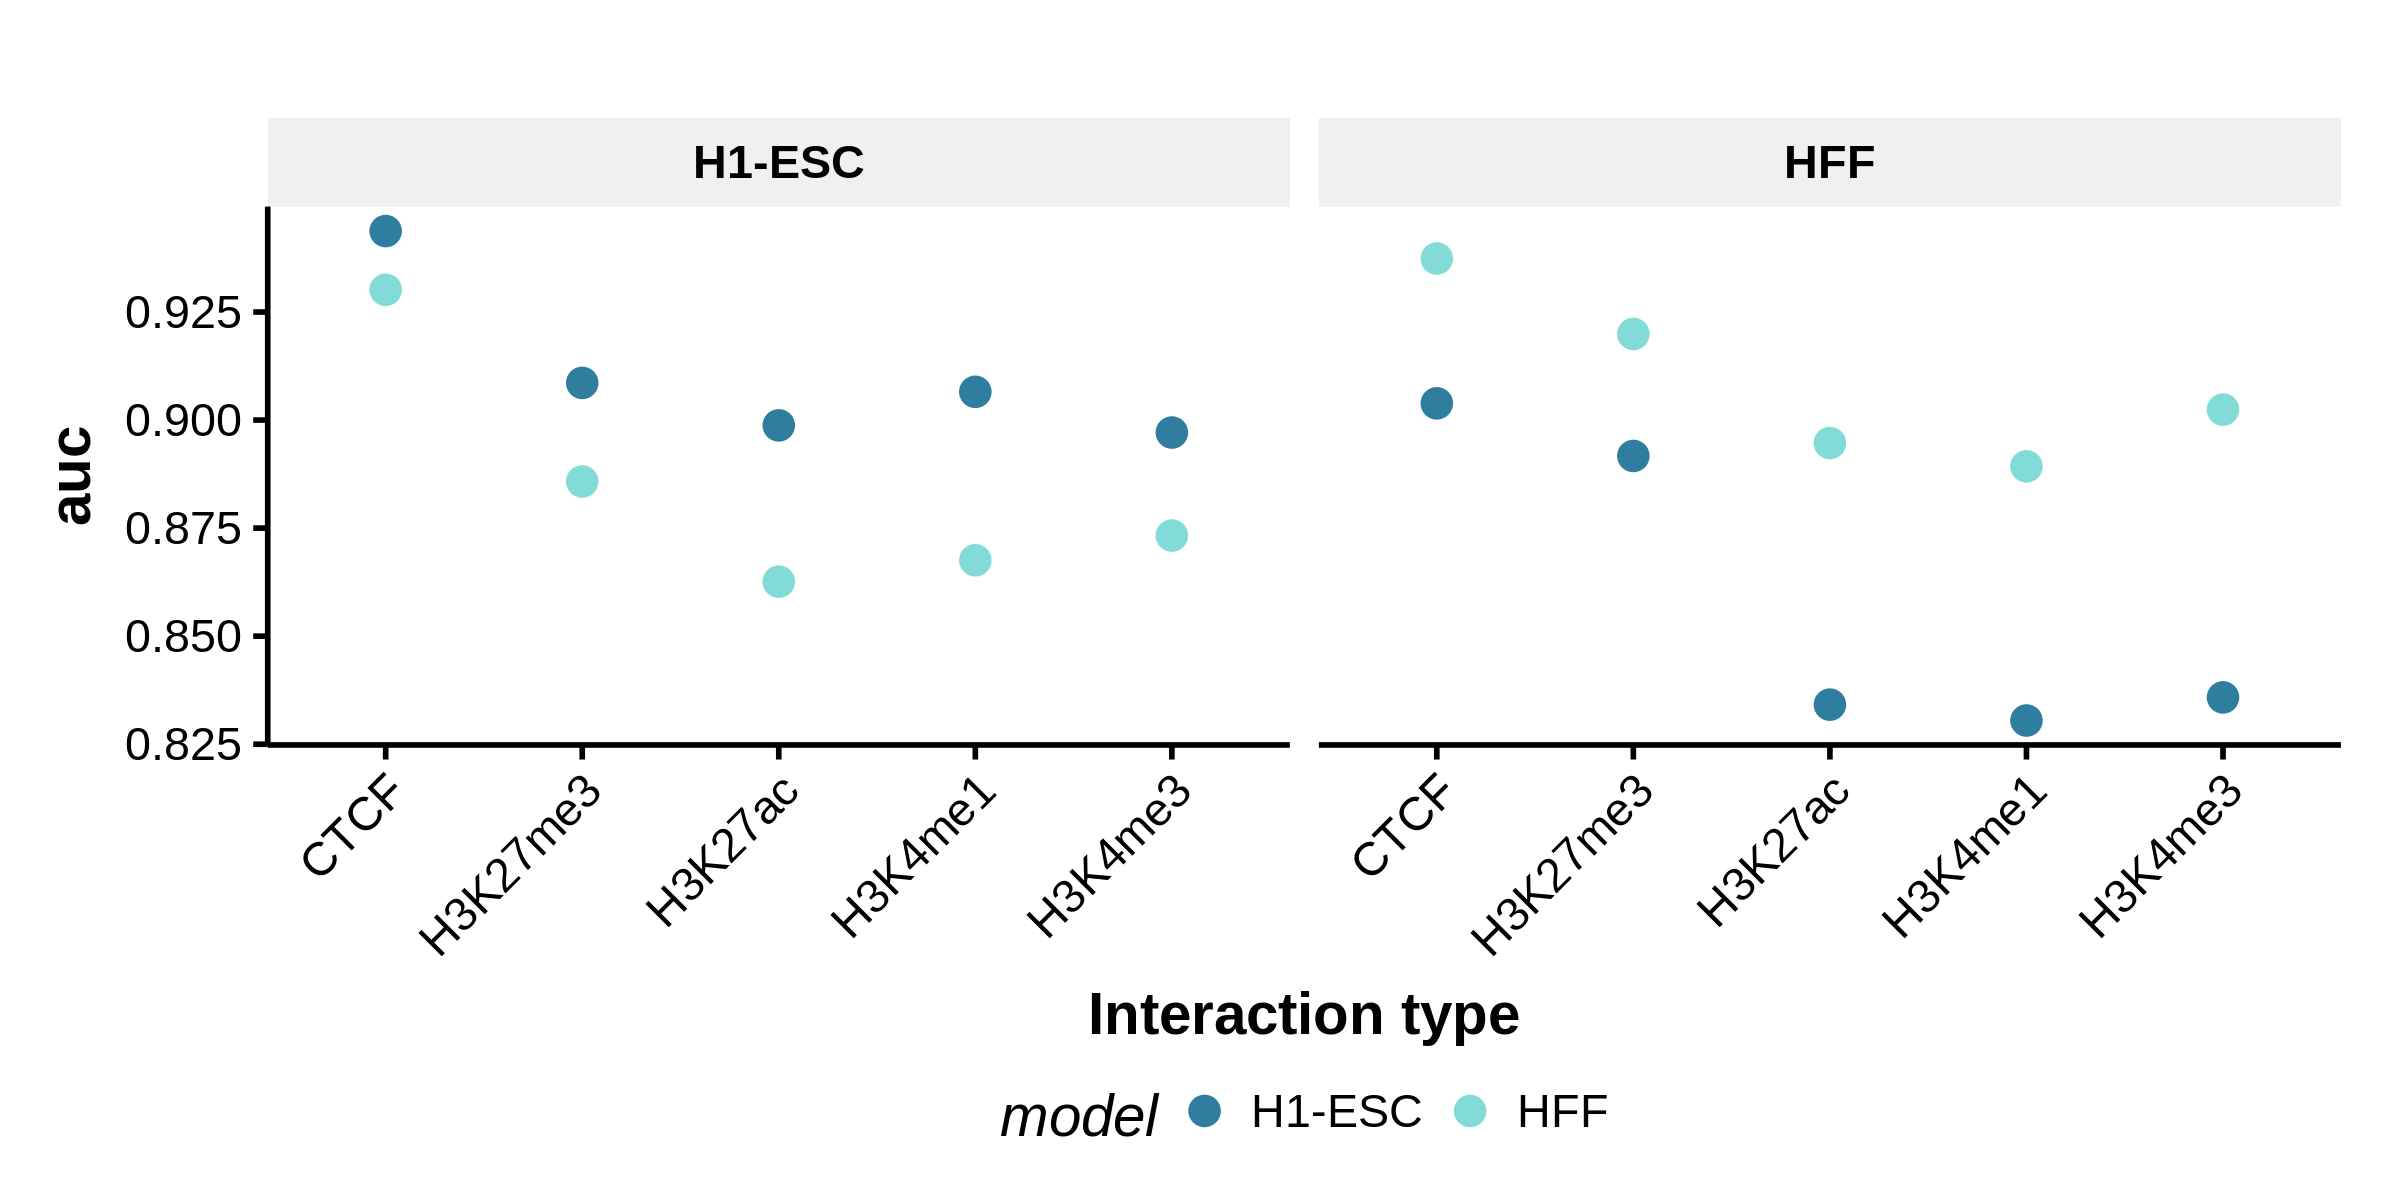

In [27]:
%%R -i plotdata -w 8 -h 4 --units in -r 300
#Plot genome interaction prediction performance for different region types 
library(ggrastr)
require(ggplot2)
require(data.table)
theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_blank(),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(0.2, "cm"),
               legend.margin = unit(0, "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}

plotdata = data.table(plotdata)
plotdata$filter_feature = factor(plotdata$filter_feature, levels=c('CTCF', 'H3K27me3','H3K27ac',  'H3K4me1', 'H3K4me3'))
p = ggplot(plotdata[levels==1,]) + geom_point(aes(x=factor(filter_feature),y=auc,color=model),size=I(3),stat='identity',position='dodge')+
    facet_grid(~target)+theme_Publication()+xlab('Interaction type')+theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+
    scale_color_manual(values=c('#307E9F','#83DBD7'))
ggsave('./figures/perf.types.pdf', device=cairo_pdf)
p

In [28]:
#1Mb model performance 

import orca_predict 
orca_predict.load_resources(models=['1M'],use_cuda=True)
from orca_predict import *

with torch.no_grad():
    mallpreds_1m = []
    for chrm in ['chr9','chr10']:
        chrlen = [len for c, len in hg38.get_chr_lens() if c == chrm][0]
        for pos in np.arange(16000000, chrlen-16000000, 500000):
            print(pos)

            sequence = hg38.get_encoding_from_coords(chrm, pos-16000000, pos+16000000)
            seqs = [torch.FloatTensor(sequence[None,:,:]), torch.FloatTensor(sequence[None,::-1,::-1].copy())]

            allpreds = []
            for iii, seq in enumerate(seqs):
                for ii, model in enumerate([h1esc_1m, hff_1m]):

                    start32 = 0
                    start16 = start32+(62+iii)*32
                    start8 = start16+(62+iii)*16
                    start4 = start8+(62+iii)*8
                    start2 = start4+(62+iii)*4
                    start1 = start2+(62+iii)*2
                    
                    if ii==0:
                        pred,_ = model.net.forward(seq[:,int(start1*4000):int(start1*4000+1000000),:].transpose(1,2))
                    else:
                        pred,_ = model.net.forward(seq[:,int(start1*4000):int(start1*4000+1000000),:].transpose(1,2))



                    allpreds.append([pred])
            mallpreds_1m.append(allpreds)


16000000


<PYTHONPATH>/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


16500000
17000000
17500000
18000000
18500000
19000000
19500000
20000000
20500000
21000000
21500000
22000000
22500000
23000000
23500000
24000000
24500000
25000000
25500000
26000000
26500000
27000000
27500000
28000000
28500000
29000000
29500000
30000000
30500000
31000000
31500000
32000000
32500000
33000000
33500000
34000000
34500000
35000000
35500000
36000000
36500000
37000000
37500000
38000000
38500000
39000000
39500000
40000000
40500000
41000000
41500000
42000000
42500000
43000000
43500000
44000000
44500000
45000000
45500000
46000000
46500000
47000000
47500000
48000000
48500000
49000000
49500000
50000000
50500000
51000000
51500000
52000000
52500000
53000000
53500000
54000000
54500000
55000000
55500000
56000000
56500000
57000000
57500000
58000000
58500000
59000000
59500000
60000000
60500000
61000000
61500000
62000000
62500000
63000000
63500000
64000000
64500000
65000000
65500000
66000000
66500000
67000000
67500000
68000000
68500000
69000000
69500000
70000000
70500000
71000000
71500000
7

In [29]:
from scipy.stats import pearsonr, spearmanr
from collections import defaultdict

p1s_1m = defaultdict(list)
p2s_1m = defaultdict(list)
t1s_1m = defaultdict(list)
t2s_1m = defaultdict(list)
levelsn = [1,2,4,8,16,32]

for i in range(len(mallpreds_1m)):
    for j in range(1):
        p1 = mallpreds_1m[i][0][j].detach().cpu().numpy()[0,0,:,:][:,:].flatten()+mallpreds_1m[i][2][j].detach().cpu().numpy()[0,0,::-1,::-1][:,:].flatten()
        t1 = malltargets[i][0][j][0,:].reshape((250,250))[:,:].flatten()
        tn1 = malltargetnans[i][0][j][0,:].reshape((250,250))[:,:].flatten()
        p2 = mallpreds_1m[i][1][j].detach().cpu().numpy()[0,0,:,:][:,:].flatten()+mallpreds_1m[i][3][j].detach().cpu().numpy()[0,0,::-1,::-1][:,:].flatten()
        t2 = malltargets[i][1][j][0,:].reshape((250,250))[:,:].flatten()
        tn2 = malltargetnans[i][1][j][0,:].reshape((250,250))[:,:].flatten()

        valid = np.isfinite(t1) * np.isfinite(t2) * (tn1<=0.25) * (tn2<=0.25) 
        p1[~valid]=np.nan
        t1[~valid]=np.nan
        p1s_1m[j].append(p1)
        t1s_1m[j].append(t1)

        p2[~valid]=np.nan
        t2[~valid]=np.nan
        p2s_1m[j].append(p2)
        t2s_1m[j].append(t2)


In [30]:
#1Mb model performance
valid = np.isfinite(t2s_1m[0]) & np.isfinite(t1s_1m[0])
#HFF
print(pearsonr(np.array(p2s_1m[0])[valid], np.array(t2s_1m[0])[valid]))
#H1-ESC
print(pearsonr(np.array(p1s_1m[0])[valid], np.array(t1s_1m[0])[valid]))

(0.7372561986588461, 0.0)
(0.7718836936318293, 0.0)


In [31]:
#1Mb model trained without auxiliary task performance

import numpy as np
import torch
from torch import nn
from orca_modules import Encoder2, Encoder, Decoder, Decoder_1m, Net


class H1esc_1M_no1d(nn.Module):
    def __init__(
        self,
    ):
        super(H1esc_1M_no1d, self).__init__()
        self.net = nn.DataParallel(Net())
        num_threads = torch.get_num_threads()
        net_dict = self.net.state_dict()
        pretrained_dict = torch.load(
            "./models_extra/orca_h1esc.net0_no1d.statedict",
            map_location=torch.device("cpu"),
        )
        pretrained_dict_filtered = {
            key: pretrained_dict[ key] for key in net_dict
        }
        self.net.load_state_dict(pretrained_dict_filtered)
        self.net.eval()

        expected_log = np.load(
            ORCA_PATH + "/resources/4DNFI9GMP2J8.rebinned.mcool.expected.res1000.npy"
        )[:1000]

        normmat = np.exp(
            expected_log[np.abs(np.arange(1000)[None, :] - np.arange(1000)[:, None])]
        )

        normmat_r = np.reshape(normmat, (250, 4, 250, 4)).mean(axis=1).mean(axis=2)
        eps = np.min(normmat_r)

        self.normmats = {1: normmat_r}
        self.epss = {1: eps}
        self.distenc = torch.log(torch.FloatTensor(self.normmats[1][None, None, :, :]))
        torch.set_num_threads(num_threads)


class Hff_1M_no1d(nn.Module):
    def __init__(
        self,
    ):
        super(Hff_1M_no1d, self).__init__()
        self.net = nn.DataParallel(Net())
        num_threads = torch.get_num_threads()
        net_dict = self.net.state_dict()
        pretrained_dict = torch.load(
            "./models_extra/orca_hff.net0_no1d.statedict",
            map_location=torch.device("cpu"),
        )
        pretrained_dict_filtered = {
            key: pretrained_dict[key] for key in net_dict
        }
        self.net.load_state_dict(pretrained_dict_filtered)
        self.net.eval()

        expected = np.exp(
            np.load(ORCA_PATH + "/resources/4DNFI643OYP9.rebinned.mcool.expected.res1000.npy")[
                :1000
            ]
        )
        normmat = expected[np.abs(np.arange(1000)[:, None] - np.arange(1000)[None, :])]

        normmat_r = np.reshape(normmat, (250, 4, 250, 4)).mean(axis=1).mean(axis=2)
        eps = np.min(normmat_r)

        self.normmats = {1: normmat_r}
        self.epss = {1: eps}
        torch.set_num_threads(num_threads)

h1esc_1m_no1d = H1esc_1M_no1d()
hff_1m_no1d = Hff_1M_no1d()
h1esc_1m_no1d.eval()
hff_1m_no1d.eval()
h1esc_1m_no1d.cuda()
hff_1m_no1d.cuda()

Hff_1M_no1d(
  (net): DataParallel(
    (module): Net(
      (lconv1): Sequential(
        (0): Conv1d(4, 64, kernel_size=(9,), stride=(1,), padding=(4,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv1d(64, 64, kernel_size=(9,), stride=(1,), padding=(4,))
        (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv1): Sequential(
        (0): Conv1d(64, 64, kernel_size=(9,), stride=(1,), padding=(4,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv1d(64, 64, kernel_size=(9,), stride=(1,), padding=(4,))
        (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
      (lconv2): Sequential(
        (0): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
        (1): Conv1d(64, 96, ker

In [32]:
with torch.no_grad():
    mallpreds_1m = []
    for chrm in ['chr9','chr10']:
        chrlen = [len for c, len in hg38.get_chr_lens() if c == chrm][0]
        for pos in np.arange(16000000, chrlen-16000000, 500000):
            print(pos)

            sequence = hg38.get_encoding_from_coords(chrm, pos-16000000, pos+16000000)
            seqs = [torch.FloatTensor(sequence[None,:,:]), torch.FloatTensor(sequence[None,::-1,::-1].copy())]

            allpreds = []

            for iii, seq in enumerate(seqs):
                for ii, model in enumerate([h1esc_1m_no1d, hff_1m_no1d]):

                    start32 = 0
                    start16 = start32+(62+iii)*32
                    start8 = start16+(62+iii)*16
                    start4 = start8+(62+iii)*8
                    start2 = start4+(62+iii)*4
                    start1 = start2+(62+iii)*2
                    
                    if ii==0:
                        distenc=torch.log(torch.FloatTensor(model.normmats[1][None,None,:,:]).cuda()).expand(seq.shape[0],1,250,250)
                        pred = model.net.forward(seq[:,int(start1*4000):int(start1*4000+1000000),:].transpose(1,2))
                    else:
                        pred = model.net.forward(seq[:,int(start1*4000):int(start1*4000+1000000),:].transpose(1,2))



                    allpreds.append([pred])
            mallpreds_1m.append(allpreds)


16000000
16500000
17000000
17500000
18000000
18500000
19000000
19500000
20000000
20500000
21000000
21500000
22000000
22500000
23000000
23500000
24000000
24500000
25000000
25500000
26000000
26500000
27000000
27500000
28000000
28500000
29000000
29500000
30000000
30500000
31000000
31500000
32000000
32500000
33000000
33500000
34000000
34500000
35000000
35500000
36000000
36500000
37000000
37500000
38000000
38500000
39000000
39500000
40000000
40500000
41000000
41500000
42000000
42500000
43000000
43500000
44000000
44500000
45000000
45500000
46000000
46500000
47000000
47500000
48000000
48500000
49000000
49500000
50000000
50500000
51000000
51500000
52000000
52500000
53000000
53500000
54000000
54500000
55000000
55500000
56000000
56500000
57000000
57500000
58000000
58500000
59000000
59500000
60000000
60500000
61000000
61500000
62000000
62500000
63000000
63500000
64000000
64500000
65000000
65500000
66000000
66500000
67000000
67500000
68000000
68500000
69000000
69500000
70000000
70500000
71000000
7

In [33]:
from scipy.stats import pearsonr, spearmanr
from collections import defaultdict

p1s_1m = defaultdict(list)
p2s_1m = defaultdict(list)
t1s_1m = defaultdict(list)
t2s_1m = defaultdict(list)
levelsn = [1,2,4,8,16,32]

for i in range(len(mallpreds_1m)):
    for j in range(1):
        p1 = mallpreds_1m[i][0][j].detach().cpu().numpy()[0,0,:,:][:,:].flatten()+mallpreds_1m[i][2][j].detach().cpu().numpy()[0,0,::-1,::-1][:,:].flatten()
        t1 = malltargets[i][0][j][0,:].reshape((250,250))[:,:].flatten()
        tn1 = malltargetnans[i][0][j][0,:].reshape((250,250))[:,:].flatten()
        p2 = mallpreds_1m[i][1][j].detach().cpu().numpy()[0,0,:,:][:,:].flatten()+mallpreds_1m[i][3][j].detach().cpu().numpy()[0,0,::-1,::-1][:,:].flatten()
        t2 = malltargets[i][1][j][0,:].reshape((250,250))[:,:].flatten()
        tn2 = malltargetnans[i][1][j][0,:].reshape((250,250))[:,:].flatten()

        valid = np.isfinite(t1) * np.isfinite(t2) * (tn1<=0.25) * (tn2<=0.25) 
        p1[~valid]=np.nan
        t1[~valid]=np.nan
        p1s_1m[j].append(p1)
        t1s_1m[j].append(t1)

        p2[~valid]=np.nan
        t2[~valid]=np.nan
        p2s_1m[j].append(p2)
        t2s_1m[j].append(t2)


In [34]:
#1M model trained without auxiliary task performance
valid = np.isfinite(t2s_1m[0]) & np.isfinite(t1s_1m[0])
#HFF
print(pearsonr(np.array(p2s_1m[0])[valid], np.array(t2s_1m[0])[valid]))
#H1-ESC
print(pearsonr(np.array(p1s_1m[0])[valid], np.array(t1s_1m[0])[valid]))

(0.7070686719905774, 0.0)
(0.7514829768285478, 0.0)


In [35]:
#Generate more prediction examples on randomly sampled positions on the test chromosomes 
from selene_utils2 import * 
sampler = RandomPositionsSamplerHiC(
    reference_sequence=MemmapGenome(
        input_path=ORCA_PATH+"/resources/Homo_sapiens.GRCh38.dna.primary_assembly.fa",
        memmapfile=ORCA_PATH+"/resources/Homo_sapiens.GRCh38.dna.primary_assembly.fa.mmap",
    ),
    target= Genomic2DFeatures([ORCA_PATH+'/resources/4DNFI9GMP2J8.rebinned.mcool::/resolutions/32000'],
                           ['r8000'],
                          (8000,8000),
                          cg=True),
    features=["r1000"],
    test_holdout=["chr8","chr9", "chr10"],
    validation_holdout=["chrY"],
    sequence_length=32000000,
    position_resolution=1000,
    random_shift=0,
    random_strand=False,
    cross_chromosome=False,
)

sampler.mode='test'

In [36]:
coords = sampler.sample(batch_size=20, coordinate_only=True)

In [37]:
mkdir -p ./figures/predictions

In [38]:
for i,((mchr,), (mstart,), (mend,), _) in enumerate(coords):
    process_region(
        mchr,
        mstart+15500000,
        mend-15500000,
        hg38,
        show_genes=False,
        file='./figures/predictions/prediction_'+str(i)+'_'+mchr+'_'+str(mstart+16000000)+'.pdf')

<PYTHONPATH>/lib/python3.7/site-packages/cooltools/lib/numutils.py:1317: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
<PYTHONPATH>/lib/python3.7/site-packages/cooltools/lib/numutils.py:1317: RuntimeWarning: divide by zero encountered in true_divide
  val_cur = ar_cur / armask_cur
../orca/orca_predict.py:396: RuntimeWarning: Mean of empty slice
  axis=4,
../orca/orca_predict.py:398: RuntimeWarning: Mean of empty slice
  axis=2,
<PYTHONPATH>/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
